# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización de librerías

In [1]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
import spacy

In [2]:
# Descargar paqueterías de nltk para el preprocesamiento de texto en caso de ser necesario descomentar
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

# Descargar paqueterías de spacy para el preprocesamiento de texto en caso de ser necesario descomentar
# spacy.cli.download('en_core_web_sm')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [5]:
# Cargar el dataframe con las reviews
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [8]:
# Visualizar
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22587,tt0365513,movie,Monster Man,Monster Man,2003,\N,95,0,"Adventure,Comedy,Horror",5.7,4350,I completely disagree with the previous review...,2,neg,0,test,3389
16364,tt0091200,movie,Hey Babu Riba,Bal na vodi,1985,\N,112,0,"Drama,Romance",7.6,764,"I was intrigued by the title, so during a smal...",9,pos,1,train,8833
20371,tt0433407,movie,Less Like Me,Less Like Me,2004,\N,112,0,"Comedy,Drama",6.7,66,I am decidedly not in the target audience for ...,10,pos,1,train,6035
2354,tt0118604,movie,An American Werewolf in Paris,An American Werewolf in Paris,1997,\N,105,0,"Comedy,Fantasy,Horror",5.1,22654,This is a title in search of a movie. It's a p...,2,neg,0,test,431
8846,tt0037632,movie,Danger Signal,Danger Signal,1945,\N,78,0,"Crime,Drama,Film-Noir",6.7,658,"Between the ages of 30 and 51, when he died of...",7,pos,1,test,2083
32674,tt0367097,movie,Straight-Jacket,Straight-Jacket,2004,\N,96,0,"Comedy,Romance",6.6,764,Director and playwright Richard Day adapted hi...,4,neg,0,test,9589
40973,tt0064873,movie,The Rain People,The Rain People,1969,\N,101,0,Drama,6.8,2793,"I have a letter from Ms. Knight, who went to c...",8,pos,1,test,6975
42315,tt0429177,movie,The Thing About My Folks,The Thing About My Folks,2005,\N,96,0,"Comedy,Drama",6.5,2272,I also viewed this film at the Santa Barbara F...,10,pos,1,train,4355
20506,tt0089489,movie,Lifeforce,Lifeforce,1985,\N,101,0,"Action,Horror,Mystery",6.1,21538,Danny Boyle was not the first person to realis...,10,pos,1,test,6718
42060,tt0090102,movie,The Supergrass,The Supergrass,1985,\N,107,0,"Comedy,Crime",6.5,539,The funniest movie from Britain I have ever se...,10,pos,1,test,2364


In [9]:
# Ver si existen valores ausentes, cantidad de observaciones, tipos de datos
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [10]:
# Estádistica descriptiva
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


**Notas generales:**
- Las peliculas van de 1894 al 2010.
- El rating promedio va de 1.4 a 9.7.
- El rating va de 1 a 10.
- Hay 47331 datos.

**Notas del problema:**
- Hay mas reseñas negativas que positivas. 
- Los textos contienen mayúsculas y signos de puntuación.
- Es un problema de clasificación. 
- El texto de las review se encuentra en la columna review.
- Pos es el objetivo.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

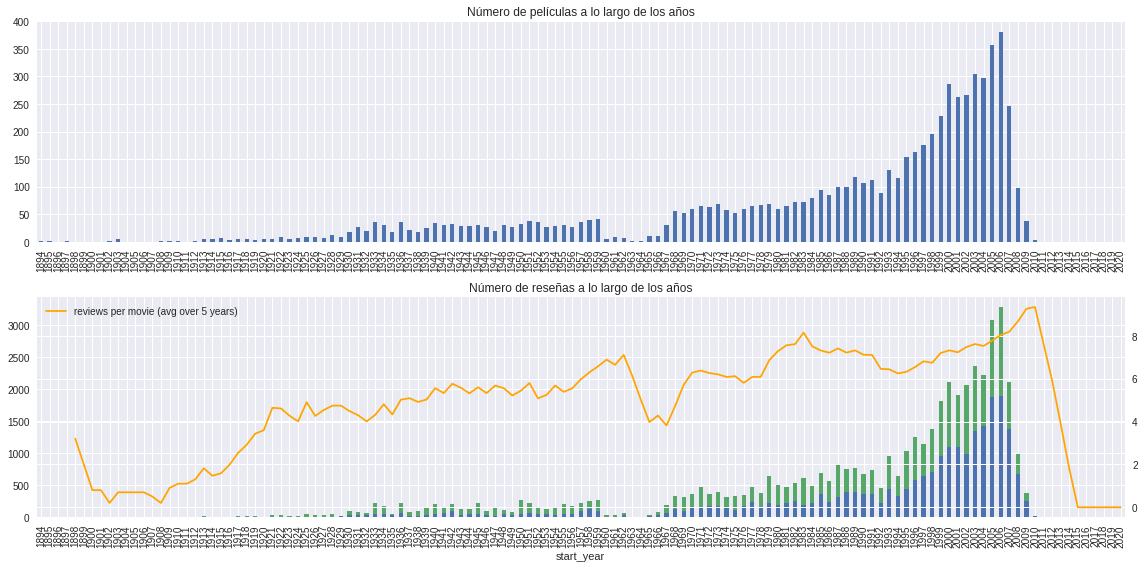

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

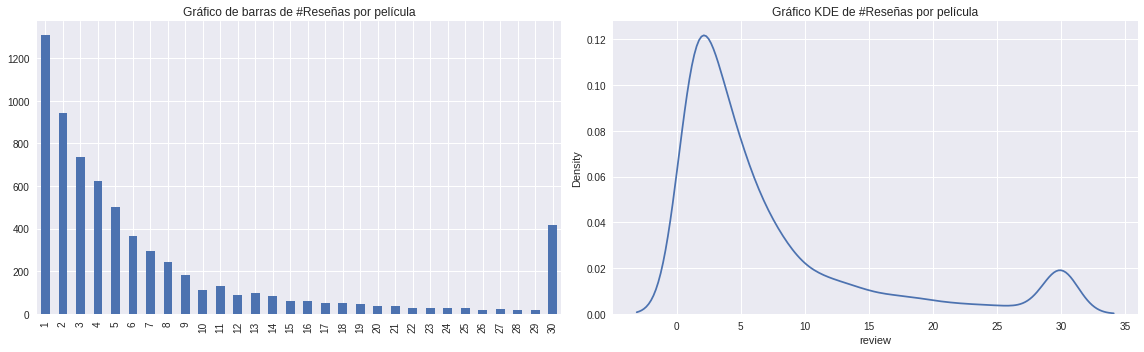

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

**Nota:**
- Parece que hay un máximo de 30 reseñas por pelicula. 
- La mayoría de las peliculs tienen entre 1 a 9 reseñas o 30 reseñas. 
- Las reseñas aumentaron en los últimos años.

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

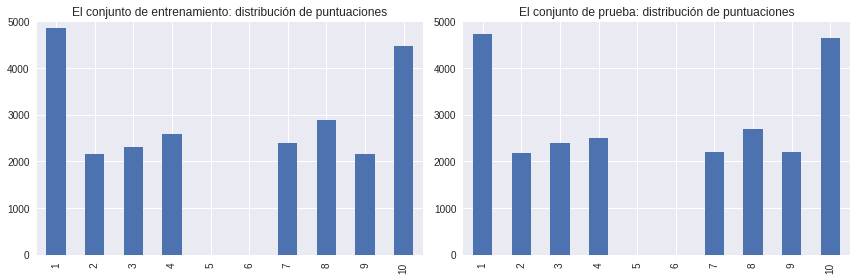

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

**Nota:**
- No hay valoraciones de 5 y 6. 
- Los conjuntos de entrenamiento y prueba tienen distribuciones similares en las puntuaciones.
- Las calificaciones 1 y 10 tienen mayor frecuencia (casi 5000) comparadas con otros. 8 es el que le sigue y tiene aprox. 3000.
- No parece haber un desbalanceo de reseñas positivas y negativas en general... y las puntuaciones parecen estar balanceadas considerando el 5 y 6 como la mitad.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


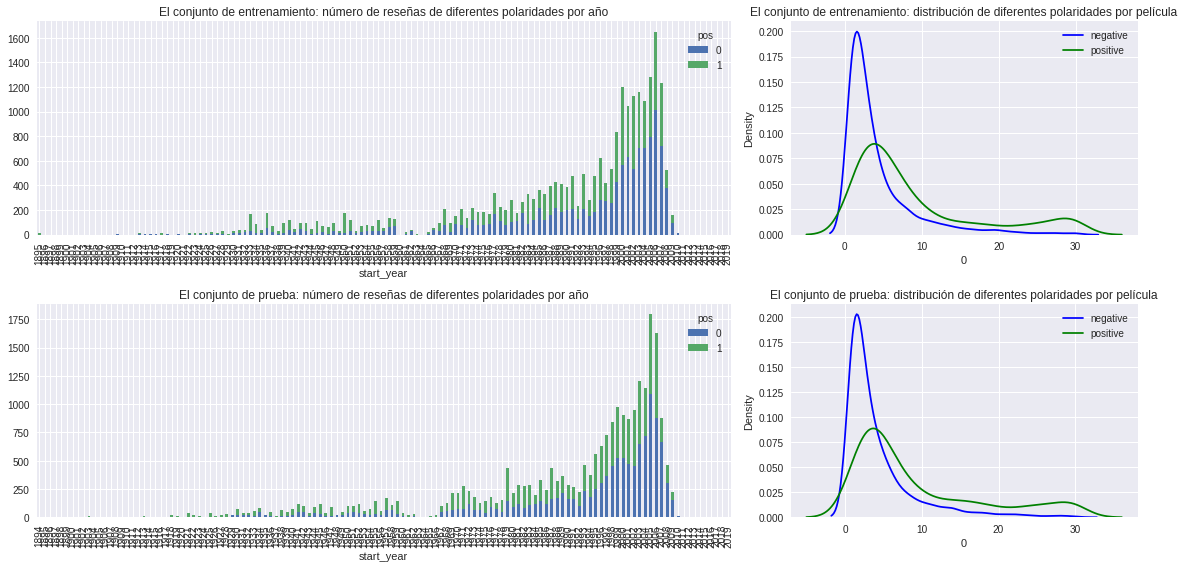

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [17]:
def  normalizacion_texto(text):
    ''' Transforma un texto. Devuelve el texto en minúsculas
    y solamente con letras y apóstrofes.
    
    '''
    pattern = r"[^a-z']"
    text = re.sub(pattern, " ", text.lower()).split()
    return " ".join(text)

In [18]:
# Crear una columna con las reviews normalizadas
df_reviews['review_norm'] = df_reviews['review'].apply(normalizacion_texto)

# Visualizar los cambios
df_reviews[['review', 'review_norm']].sample(10)

,review,review_norm
19970,This was absolutely one of the best movies I'v...,this was absolutely one of the best movies i'v...
8113,"Sadly,this is not 'the best British gore film ...",sadly this is not 'the best british gore film ...
22963,Musings: Pure delight from beginning to end. N...,musings pure delight from beginning to end not...
30854,Eddy Murphy and Robert De Niro should be a com...,eddy murphy and robert de niro should be a com...
33044,"The sun should set on this movie, forever. It ...",the sun should set on this movie forever it go...
24652,I can only agree with taximeter that this is a...,i can only agree with taximeter that this is a...
8049,It took a loan out film to Columbia for Gene K...,it took a loan out film to columbia for gene k...
12250,Eye in the Labyrinth is not your average Giall...,eye in the labyrinth is not your average giall...
2644,As I sat in the theater almost crying to mysel...,as i sat in the theater almost crying to mysel...
6460,"I thoroughly enjoyed Carmen, better than Origi...",i thoroughly enjoyed carmen better than origin...


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

           train  test
Exactitud    NaN   NaN
F1           0.5   0.5
APS          0.5   0.5
ROC AUC      0.5   0.5


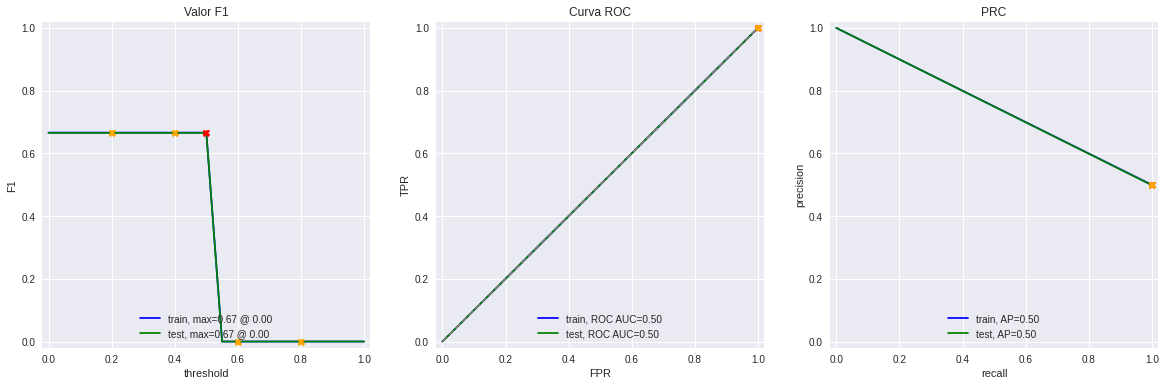

In [20]:
# Inicializar el modelo dummy y ajustar
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(df_reviews_train, train_target)

# Evaluar el modelo para F1, APS, ROC-AUC
evaluate_model(dummy_clf, df_reviews_train, train_target, df_reviews_test, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [21]:
def preprocess_text_nltk(text):
    ''' Preprocesamiento de un texto con la librería NLTK.
    Inicluye tokenización, limpieza de stopwords y lematización.
    El texto de entrada debe estar en minúsculas y sin signos de puntuación.
    Solo acepta texto en ingles.
    '''
    # Tokenización
    words = nltk.word_tokenize(text)

    # Eliminar stopwords
    stop_words = set(nltk_stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Lematización
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return ' '.join(lemmatized_words)

In [22]:
def vector_tf_idf(features_train, features_test):
    ''' Vectoriza un conjunto (texto) de entrenamiento y prueba previamente
    procesados '''
    vectorizer = TfidfVectorizer()
    features_train_tfidf = vectorizer.fit_transform(features_train)
    features_test_tfidf = vectorizer.transform(features_test)
    return features_train_tfidf, features_test_tfidf, vectorizer

In [23]:
def logistic_reg_model(features_train, target_train):
    model = LogisticRegression()
    model.fit(features_train, target_train)
    return model

In [24]:
# Preprocesamiento de las reviews
features_train_preprocessed_1 = df_reviews_train['review_norm'].apply(preprocess_text_nltk)
features_test_preprocessed_1 = df_reviews_test['review_norm'].apply(preprocess_text_nltk)

# Vectorzación
features_train_tf_idf_1, features_test_tf_idf_1, vectorizer_1 = vector_tf_idf(features_train_preprocessed_1, 
                                                                            features_test_preprocessed_1)

# Ajustar el modelo de regresión lineal
model_lr_1 = logistic_reg_model(features_train_tf_idf_1, train_target)

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


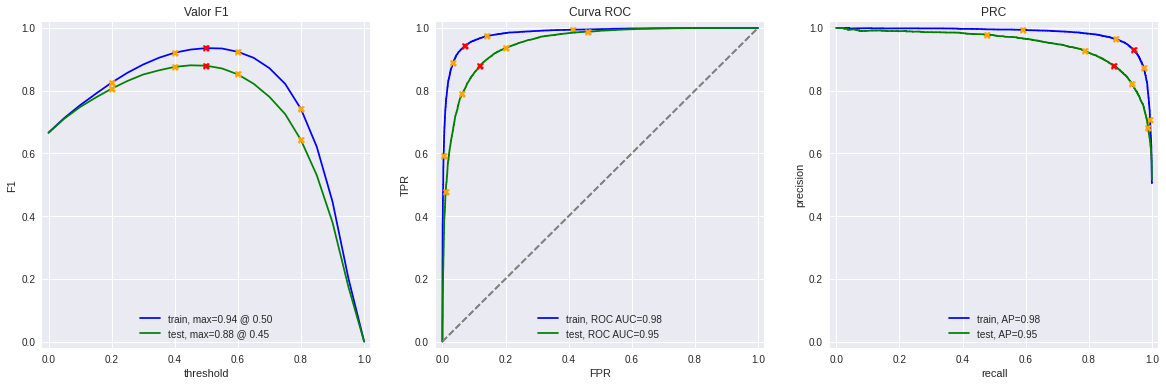

In [25]:
# Evaluar el modelo para F1, APS, ROC-AUC
evaluate_model(model_lr_1, features_train_tf_idf_1, train_target, features_test_tf_idf_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [26]:
# Cargar el modelo en ingles
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def preprocess_text_spacy(text):
    ''' Se preprocesa un texto encrito en ingles utilizando
    la libreria de spacy. Se tokeniza y lematiza el texto'''
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [28]:
# Inicializar 
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Preprocesamiento de las reviews
features_train_preprocessed_3 = df_reviews_train['review_norm'].apply(preprocess_text_spacy)
features_test_preprocessed_3 = df_reviews_test['review_norm'].apply(preprocess_text_spacy)

# Vectorzación
features_train_tf_idf_3, features_test_tf_idf_3, vectorizer_3 = vector_tf_idf(features_train_preprocessed_3, 
                                                                              features_test_preprocessed_3)

# Ajustar el modelo de regresión lineal
model_lr_3 = logistic_reg_model(features_train_tf_idf_3, train_target)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


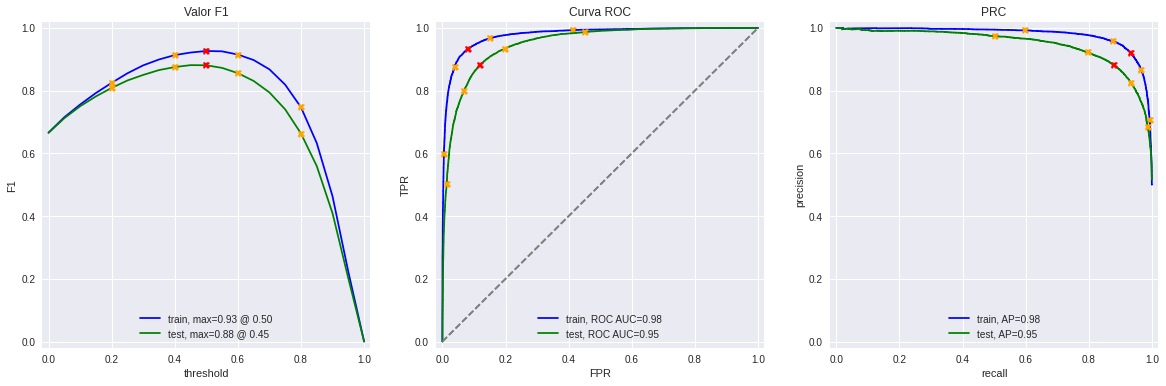

In [29]:
# Evaluar el modelo para F1, APS, ROC-AUC
evaluate_model(model_lr_3, features_train_tf_idf_3, train_target, features_test_tf_idf_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [30]:
# Ajustar el modelo LGBMClassifier
model_4 = LGBMClassifier()
model_4.fit(features_train_tf_idf_3, train_target)

LGBMClassifier()

           train  test
Exactitud    NaN   NaN
F1          0.92  0.86
APS         0.98  0.94
ROC AUC     0.98  0.94


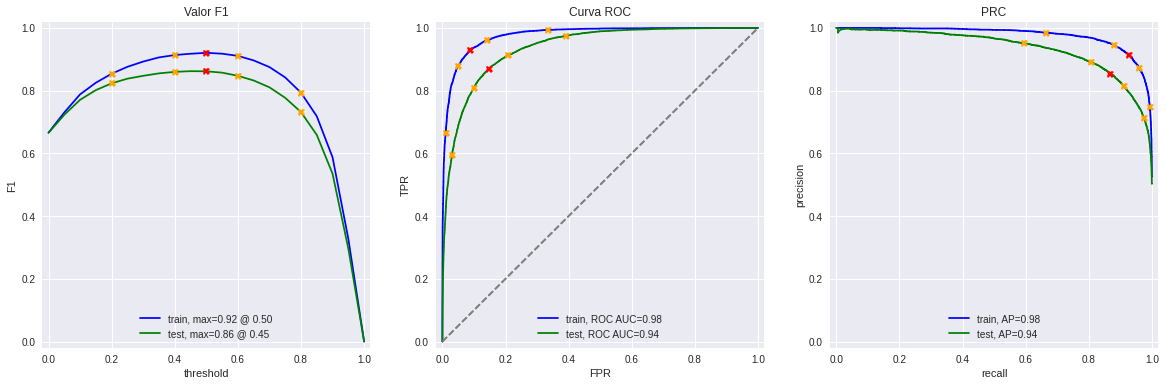

In [31]:
# Evaluar el modelo para F1, APS, ROC-AUC
evaluate_model(model_4, features_train_tf_idf_3, train_target, features_test_tf_idf_3, test_target)

## Mis reseñas

In [32]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(normalizacion_texto) # <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 1

In [33]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_lr_1.predict_proba(vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.36:  i did not simply like it not my kind of movie
0.31:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.27:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i didn't expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.17:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [34]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_lr_3.predict_proba(vectorizer_3.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.27:  i did not simply like it not my kind of movie
0.30:  well i was bored and felt asleep in the middle of the movie
0.53:  i was really fascinated with the movie
0.40:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.40:  i didn't expect the reboot to be so good writers really cared about the source material
0.70:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.10:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [35]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(vectorizer_3.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.37:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.63:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.78:  i didn't expect the reboot to be so good writers really cared about the source material
0.81:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.20:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 9

In [ ]:
#texts = my_reviews['review_norm']

#my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

#my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
#    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

- No hubo diferencia significativa entre las métricas f1 y roc-auc al utilizar la librería de spacy y nltk para lematizar y tokenizar. nltk fue 0.01 mejor en el conjunto de entrenamiento para f1. 
- Spacy tarda notablemente más que nltk en lematizar y tokenizar. 
- Los modelos de regresión logística y LGBM obtuvieron una métrica f1 superior a la propuesta (0.85). 
- El mejor modelo fue el de regresión logística con 0.88 para F1. 
- A pesar de las métricas similares entre usar spacy y nltk, en los comentarios de prueba se obtuvieron predicciones que varian ligeramente.